In [ ]:
# Sección 1 - Importando librerias

! pip install fredapi
import seaborn as sns
import matplotlib.pyplot as plt
import fredapi
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [ ]:
tickers = ["AAPL","NKE","NVDA"]
end_date = datetime.today()
start_date = end_date - timedelta(days = 10*365)
print(start_date)

2014-09-26 23:03:33.467221


In [ ]:
# Descargar Adj. Close Prices
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date )
    adj_close_df[ticker] = data["Adj Close"]
print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  AAPL        NKE        NVDA
Date                                         
2014-09-29   22.222099  39.807873    0.442659
2014-09-30   22.364164  39.843605    0.440986
2014-10-01   22.015661  39.173588    0.436683
2014-10-02   22.175488  39.888271    0.434771
2014-10-03   22.113331  40.330482    0.435728
...                ...        ...         ...
2024-09-17  216.789993  80.639999  115.589996
2024-09-18  220.690002  80.900002  113.370003
2024-09-19  228.869995  80.980003  117.870003
2024-09-20  228.199997  86.519997  116.000000
2024-09-23  226.470001  86.199997  116.260002

[2513 rows x 3 columns]


In [ ]:
# Sección 3 - Calcular retornos (Lognormal)

log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

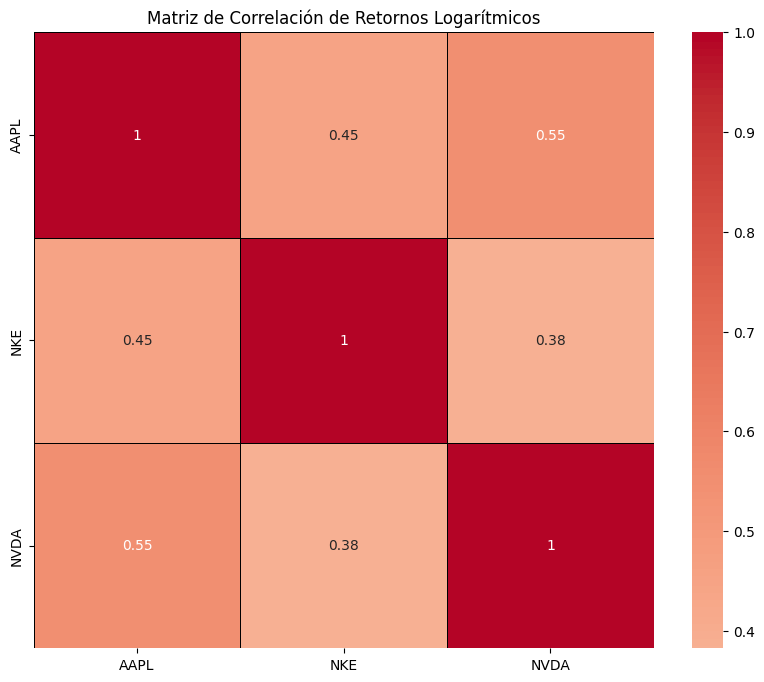

In [ ]:
# Calcular la matriz de correlación de los retornos logarítmicos
correlation_matrix = log_returns.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')

# Título del gráfico
plt.title('Matriz de Correlación de Retornos Logarítmicos')

# Mostrar el gráfico
plt.show()

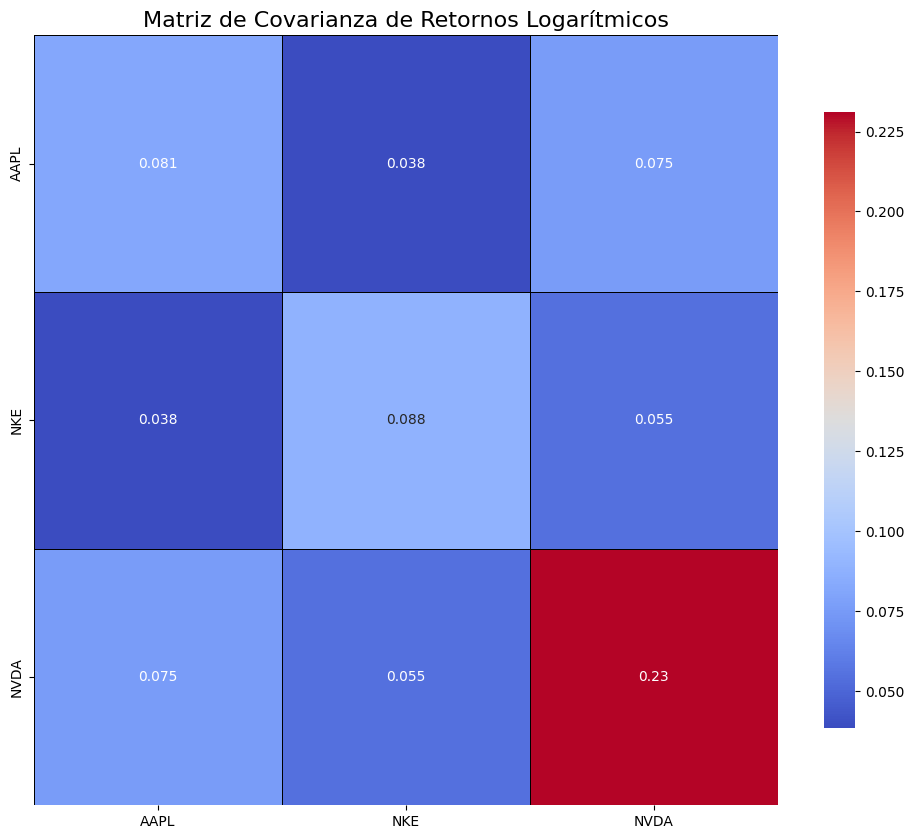

In [ ]:
# Sección 4 - Calcular la Matriz de Covarianza
cov_matrix = log_returns.cov() * 252

# Crear el mapa de calor para la Matriz de Covarianza con colores más llamativos
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# Título del gráfico
plt.title('Matriz de Covarianza de Retornos Logarítmicos', fontsize=16)

# Mostrar el gráfico
plt.show()

In [ ]:
# Seccion 5 - Calculando las métricas del portafolio
# 1 - Riesgo (Desviacion Estandar)

def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# 2 - Retornos Esperados (En base a histórico)

def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

# 3 - Ratio Sharpe (Retorno - Risk Free Rate / Riesgo)

def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [ ]:
# Sección 6 - Optimización del Portafolio

# 1 - Setear el Risk-Free Rate

from fredapi import Fred

# Replace "your_api_key" with your actual FRED API key
fred = Fred(api_key = "2dc45be11d4e31dd45dab042097f393a")
ten_year_treasury_rate = fred.get_series_latest_release("GS10") / 100

# Setear Risk-Free Rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

# 2 - Definir la funcion a minimizar (Sharpe Ratio negativo)
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate)

# 3 - Definir las restricciones del portafolio (Suma de los weights = 1)
constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

# 4 - Definir los pesos iniciales

initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

# 5 - Optimizar los pesos para maximizar Ratio Sharpe

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method = "SLSQP", constraints = constraints, bounds = bounds)

# 6 - Obtener los pesos óptimos

optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

0.0387
[0.33333333 0.33333333 0.33333333]
Optimal Weights:
AAPL: 0.5000
NKE: 0.0000
NVDA: 0.5000
Expected Annual Return: 0.3959
Expected Volatility: 0.3404
Sharpe Ratio: 1.0494


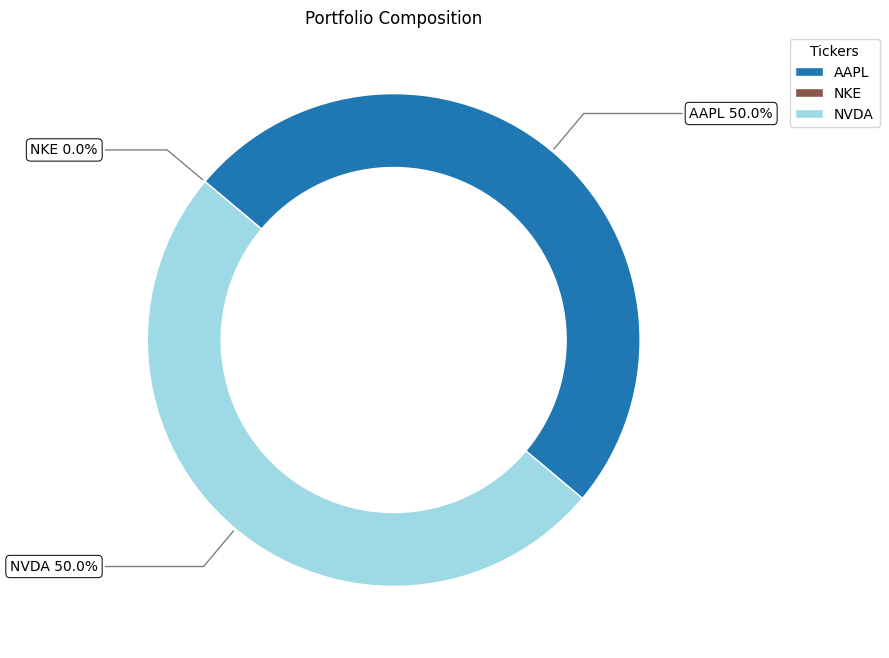

In [ ]:
# 7 - Display del Porfolio en Plot

import matplotlib.pyplot as plt
import numpy as np

# Nombres de los tickers y los pesos óptimos
labels = tickers
sizes = optimal_weights

# Colores para cada sección del gráfico
colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))

# Crear el gráfico de anillo
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(sizes, colors=colors, wedgeprops=dict(width=0.3, edgecolor='w'), startangle=-40)

# Añadir las etiquetas fuera del gráfico
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="w", linewidth=0.7)
kw = dict(arrowprops=dict(arrowstyle="-", color='gray'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{labels[i]} {sizes[i]*100:.1f}%", xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw)

# Añadir una leyenda en la esquina superior derecha
ax.legend(wedges, labels, title="Tickers", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title('Composición del Portafolio')

# Ajustar los márgenes para que la leyenda no se superponga con las etiquetas externas
plt.subplots_adjust(right=0.75)
plt.show()
